## Домашнє завдання: Поліноміальні ознаки. Pipelines

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


#### **Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.**

В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
file_name = '/content/drive/MyDrive/ML/data/bccp/train.csv'
dir_path = 'drive/My Drive/ML/data/bccp/lab'

F1 score: 0.64
Area under ROC score on Train dataset: 0.75


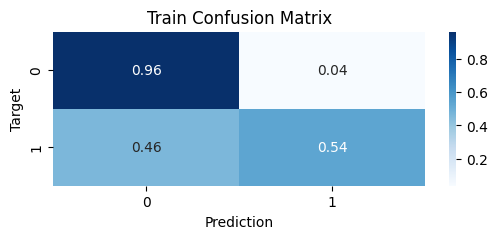

F1 score: 0.64
Area under ROC score on Validation dataset: 0.76


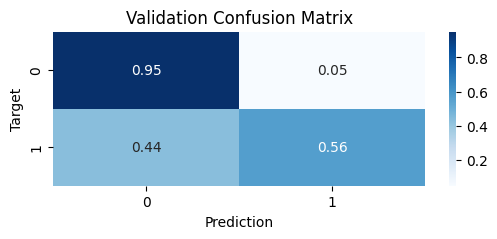

['drive/My Drive/ML/data/bccp/lab/bccp_pipe.joblib']

In [ ]:
raw_df = pd.read_csv(file_name, index_col=0)

# Створюємо трен. і вал. набори
input_cols = [col for col in raw_df.columns if col not in ['Exited', 'id', 'Surname', 'CustomerId']]
target_col = 'Exited'

train_inputs, val_inputs, train_targets, val_targets = train_test_split(raw_df[input_cols], raw_df[target_col],  test_size=0.2, random_state=42, stratify = raw_df[target_col])

# Виявляємо числові і категоріальні колонки
numeric_cols = [col for col in raw_df.select_dtypes(include=['int64', 'float64']).columns if col in input_cols]
categorical_cols = [col for col in raw_df.select_dtypes(include=['object']).columns if col in input_cols]

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, preds)
    f1 = f1_score(targets, preds, pos_label=1)
    print("F1 score: {:.2f}".format(f1))
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')

    plt.figure(figsize=(6, 2))
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, f'{dir_path}/bccp_pipe.joblib')


#### **Завдання 2**

Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

F1 score: 0.70
Area under ROC score on Train with Polynomial Features (2 degree) dataset: 0.79


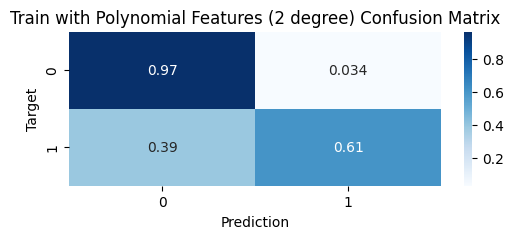

F1 score: 0.69
Area under ROC score on Validation with Polynomial Features (2 degree) dataset: 0.79


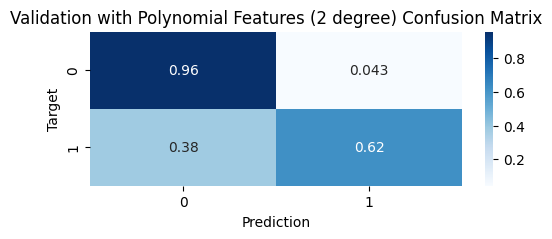

In [ ]:
numeric_transformer_pol = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pol', PolynomialFeatures(degree=2))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor_pol = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_pol, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_pol_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_pol),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline_pol_2.fit(train_inputs, train_targets)

train_preds_pol = predict_and_plot(model_pipeline_pol_2, train_inputs, train_targets, name='Train with Polynomial Features (2 degree)')
val_preds_pol = predict_and_plot(model_pipeline_pol_2, val_inputs, val_targets, name='Validation with Polynomial Features (2 degree)')

**Спостереження**:

Згідно F1 score та на значення ROC_AUC score, що є близькими на обох наборах можемо сказати, що модель добре генералізує і не втрачає точності на нових даних.

З матриці плутанини бачимо, що модель добре пербачає негативний клас, що є мажоритарним, в той же час для мінорного класу модель передбачає гірше і робить помилки майже у 40% для обох датасетів.

Можемо сказати, що overfit або underfit не спостерігаються, оскільки значення метрик якості моделі є достатньо близькими і для тренувальних і для валідаційних даних. Гірші показники на тренувальних даних скоріше обумовлені диcбалансом класів ніж перенавчанням.

#### **Завдання 3**

Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

F1 score: 0.74
Area under ROC score on Train with Polynomial Features (4 degree) dataset: 0.82


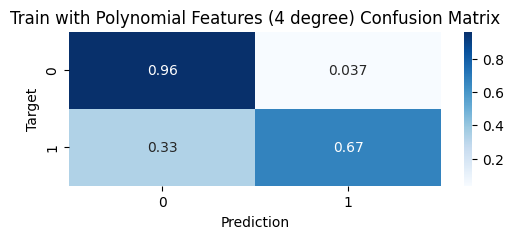

F1 score: 0.72
Area under ROC score on Validation with Polynomial Features (4 degree) dataset: 0.81


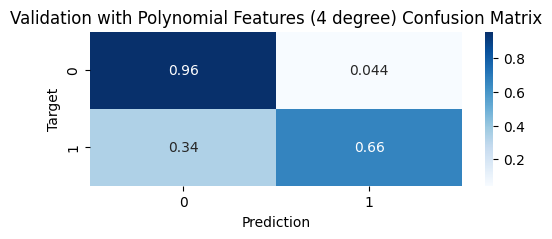

In [ ]:
numeric_transformer_pol = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pol', PolynomialFeatures(degree=4))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor_pol = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_pol, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_pol_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_pol),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline_pol_4.fit(train_inputs, train_targets)

train_preds_pol = predict_and_plot(model_pipeline_pol_4, train_inputs, train_targets, name='Train with Polynomial Features (4 degree)')
val_preds_pol = predict_and_plot(model_pipeline_pol_4, val_inputs, val_targets, name='Validation with Polynomial Features (4 degree)')

**Спостереження**:

Значення метрик F1 Score та ROC AUC вже значно кращі, ніж на минулій моделі.
Модель добре працює і на тестових даних, демонструючи лише незначне зниження продуктивності порівняно з тренувальними даними.

Так як різниця значень метрик невелика між тренувальним і тестувальним наборами даних можемо сказати, що модель добре генералізує.

Можемо сказати, що модель не має ознак  overfit чи underfit, але все ж таки бачимо, що модель гірше визначає позитивний клас, проте гарно виявляє негативний.



#### **Завдання 4. Перенавчання і регуляризація**


  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [ ]:
data_file_name = '/content/drive/MyDrive/ML/data/regression_data.csv'
reg_rew_df = pd.read_csv(data_file_name)
reg_rew_df.head(3)

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482


In [ ]:
train_df, test_df = train_test_split(reg_rew_df, test_size=0.2, random_state=42)

In [ ]:
input_cols = [col for col in reg_rew_df.columns if col != 'target']
target_col = 'target'

In [ ]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [ ]:
def count_loss(target, prediction):
  return np.sqrt(mean_squared_error(target, prediction))

def count_resuduals(target, prediction):
    train_residuals = target - prediction
    return train_residuals

def evaluate(model, inputs, targets, name=""):
    preds = model.predict(inputs)
    loss = count_loss(targets, preds)
    residuals = count_resuduals(targets, preds)
    print(f"Loss: {loss}")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(targets, preds, alpha=0.6, color="blue")
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], color="red", linestyle="--",)
    plt.title(f"Графік розсіювання")
    plt.xlabel("Реальні значення")
    plt.ylabel("Передбачення")
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True, bins=30, color="blue", label="Залишки")
    plt.title("Гістограма залишків")
    plt.xlabel("Залишки")
    plt.ylabel("Частота")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.suptitle(name, fontsize=16)
    plt.show()

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pol', PolynomialFeatures(degree=5))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols),
])
model_pipeline_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

model_pipeline_reg.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pol',
                                                                   PolynomialFeatures(degree=5))]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'feature_4',
                                                   'feature_5'])])),
                ('classifier', LinearRegression())])

Loss: 3.7763558710745e-13


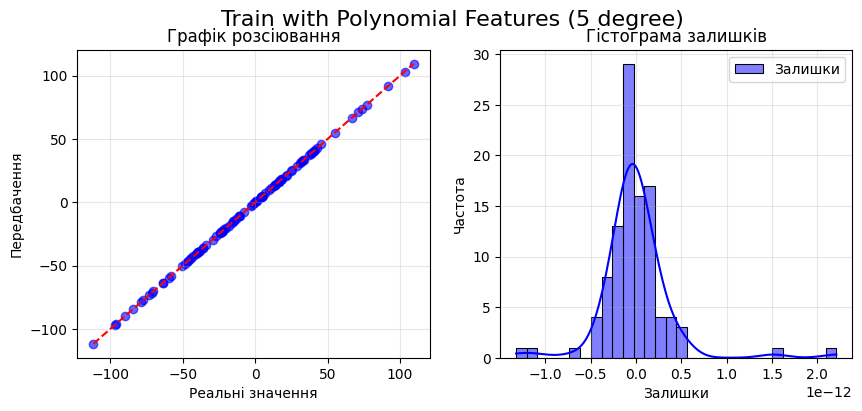

Loss: 35.62805277364273


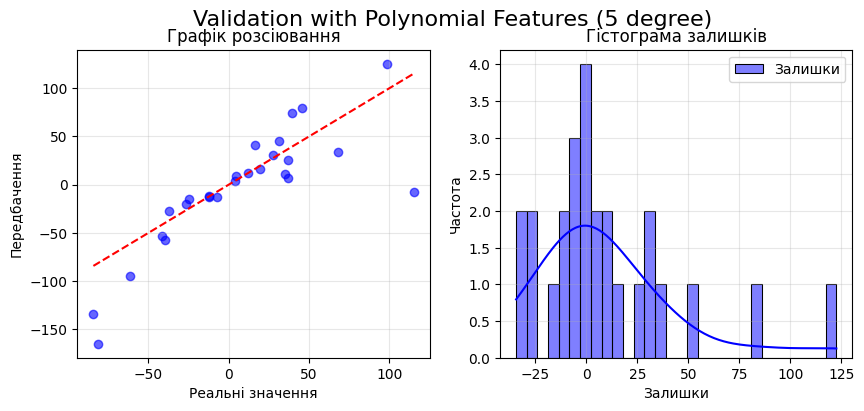

In [ ]:
train_preds = evaluate(model_pipeline_reg, train_inputs, train_targets, name='Train with Polynomial Features (5 degree)')
test_preds = evaluate(model_pipeline_reg, test_inputs, test_targets, name='Validation with Polynomial Features (5 degree)')

**Висновок**:


Маємо значення RMSE:
- на тренувальних даних: 3.7763558710745e-13
- на тестових даних: 35.62805277364273

Бачимо, що на тренувальному наборі знаечнння RMSE має дуже маленьке значення, що фактично свідчить про те, що модель практично ідеально підлаштувалась під тренувальні дані.

Також можемо подивитись на залишки, які також близькі до нуля.
Дивлячись на графік розіювання бачимо відповідність між реальними та передбачуваними даними.

На тестувальному наборі бачимо вже значно більше значення RMSE відносно тренувального набору. Розподіл залишків ширший, а також є наявні відхилення.
На графіку розсіювання, також бачимо, що дані трішки розкидані.  

Модель дуже добре працює на тренувальному наборі, але значно гірше на тестовому, що говорить про перенавчання.

Модель погано генералізує, про що говорить нам різниця між значенням функції втрат.  


#### **Завдання 5**

Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

##### Lasso

Loss: 2.1975198414735795


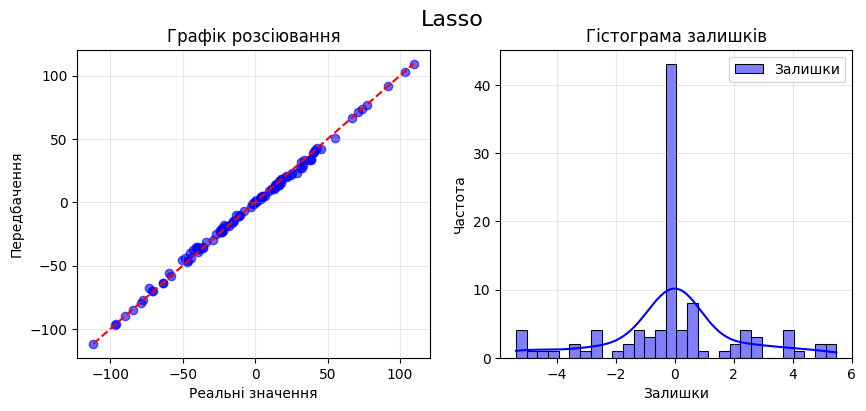

Loss: 14.944979186492345


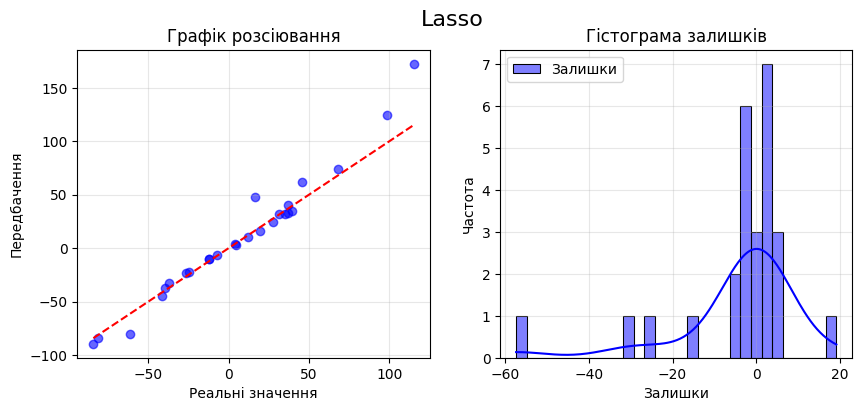

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pol', PolynomialFeatures(degree=20))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols),
    ])

lasso_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Lasso())
])

lasso_model_pipeline.fit(train_inputs, train_targets)

train_preds = evaluate(lasso_model_pipeline, train_inputs, train_targets, name='Lasso')
test_preds = evaluate(lasso_model_pipeline, test_inputs, test_targets, name='Lasso')

##### Ridge

Loss: 30.879121772880048


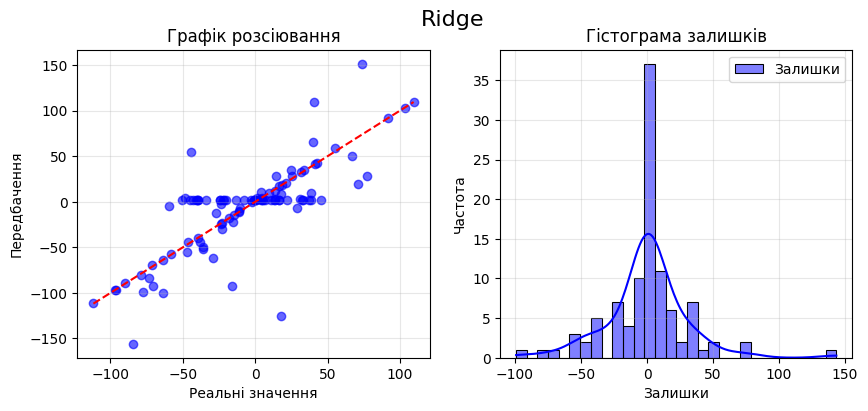

Loss: 152443.03159457212


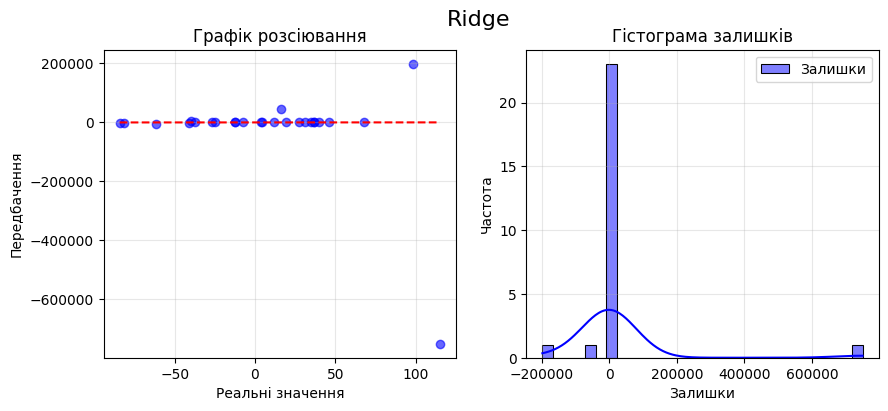

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pol', PolynomialFeatures(degree=20)),
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols),
    ])

ridge_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Ridge())
])

ridge_model_pipeline.fit(train_inputs, train_targets)

train_preds = evaluate(ridge_model_pipeline, train_inputs, train_targets, name='Ridge')
test_preds = evaluate(ridge_model_pipeline, test_inputs, test_targets, name='Ridge')

##### ElasticNet

Loss: 9.14765783097674


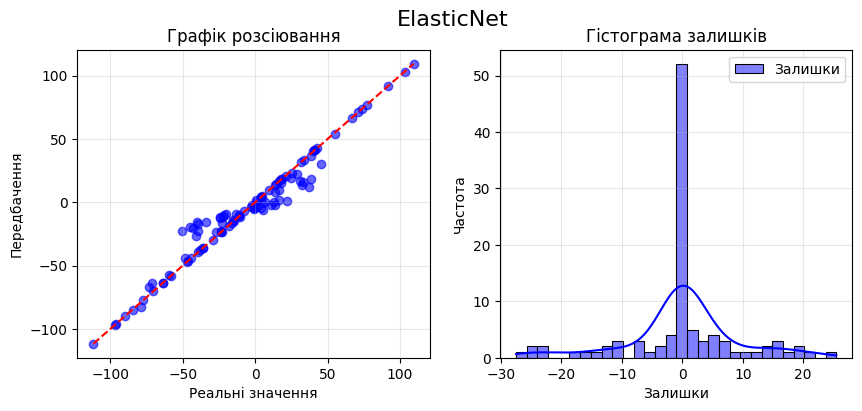

Loss: 241.66385610406374


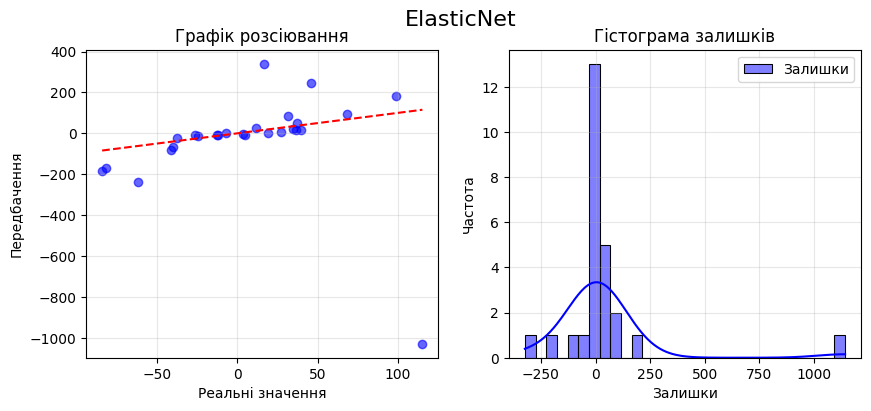

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pol', PolynomialFeatures(degree=20)),
    ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols),
    ])

en_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ElasticNet())
])

en_model_pipeline.fit(train_inputs, train_targets)

train_preds = evaluate(en_model_pipeline, train_inputs, train_targets, name='ElasticNet')
test_preds = evaluate(en_model_pipeline, test_inputs, test_targets, name='ElasticNet')

###### **Висновки**:
***Lasso***

Маємо значення RMSE:
- на тренувальних даних: 0.6864
- на тестових даних: 202.4038

На тренувальних даних модель гарно передбачає, точки на діаграмі розсіювання лежать чітко на діагональній лінії. На тестових даних вже бачимо, що на діаграмі розіювання є відхилення. Що може говорити про перенавчання.

На тренувальних даних розподіл залишків візуально близький до нормального, і залишки є близбкими до нуля, що говорить про те, що модель гарно передбачає.
На тестових даних залишки вже мають значно ширший розподіл.


Можемо сказати, що модель має проблеми з генералізацію.

***Ridge***

Маємо значення RMSE:
- на тренувальних даних: 30.8791
- на тестових даних: 152443.0316

На тренувальних даних модель працює непогано, хоча точки на діаграмі розсіювання не так ідеально розташовані на діагоналі як у випадку Lasso.
На тестових даних, можемо бачити, що точки на діаграмі розіювання мають ще більше відхилення

Залишки на тренувальних даних мають візуально нормальний розподіл, але розподіл більш широкий ніж у випадку моделі Lasso.
На тнстових данних розподіл залишкив досить широкий.

Можемо сказати, що модель гірше генералізує за модель Lasso.

***ElasticNet***

Маємо значення RMSE:
- на тренувальних даних: 9.1477
- на тестових даних: 241.6639

На тренувальних даних модель працює непогано, хоча і є незначні відхилення від діагоналі.
На тестових даних спостерігається деяке погіршення якості, але відхилення менші, ніж у Ridge.

Залишки на тренувальних даних мають візуально схожий до нормального розподілу, хоча і трохи зміщений та відносно вузький (ширше за Lasso та вужче за Ridge), що свідчить про хорошу адаптацію до тренувальних даних.

На тестових даних залишки ширші, але значно кращі, ніж у Lasso та Ridge.

Найкраще генералізує модель ElasticNet, з візуалізацій на тестових даних для даної моделі бачимо, що в цілому точки не сильно розкидані, і розподіл залишків не такий широкий,  так як ElasticNet є комбінацією Lasso та Ridge, модель більше узгоджується і на тренувальних даних модель не надто адаптується до даних (як це робить Lasso), а на тестових не допускає таких сильних викидів (як Ridge).

***Порівняння з LinearRegression***

Маємо значення RMSE:
- на тренувальних даних: 3.7763558710745e-13
- на тестових даних: 35.62805277364273


Лінійна регресія показує найгірший результат серед вих моделей.
Маємо дуже велику різницю RMSE між тренувальними та тестовими даними. Можемо сказати, що дана модель найгірше генералізує, і є найменш стійкою до перенавчання.

##### **Додатковий аналіз ознак**

In [ ]:
df = reg_rew_df.copy()

In [ ]:
df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,-0.082039,-0.017872,0.092293,-0.076084,0.053098,-3.902984
std,0.941214,1.065887,0.978557,0.910588,1.004498,45.466621
min,-3.241267,-2.619745,-1.913280,-2.211135,-2.301921,-111.753810
25%,-0.699726,-0.756351,-0.553649,-0.730367,-0.772825,-37.339533
50%,-0.066080,-0.161286,0.120296,0.018418,0.013002,-0.641298
75%,0.529804,0.679598,0.624120,0.519347,0.787085,25.464414
max,2.122156,3.852731,3.078881,2.314659,2.075401,115.125907


Можемо подивитись на корреляцію змінних

In [ ]:
def corr_target_measure(df, target_variable, threshold=None, visualize=False):
  corr = df.corr()

  if threshold:
    corr = corr[(abs(corr) >= 0.5) & (abs(corr) < 0.9999)]

  if visualize:
    plt.figure(figsize = (10,6))
    sns.heatmap(data = corr, annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
    plt.show()

  corr = corr[target_variable].dropna(axis=0, how='all')
  print(f"Ознаки, що корелюють з цільовою змінною на більш ніж {threshold} за модулем")
  print(f"{'Незалежна змінна':<20} {'Кореляція з цільовою змінною ' + target_variable :>10}")
  for i, v in corr.items():
    print(f"{i:<20s} {v:>10.4f}")

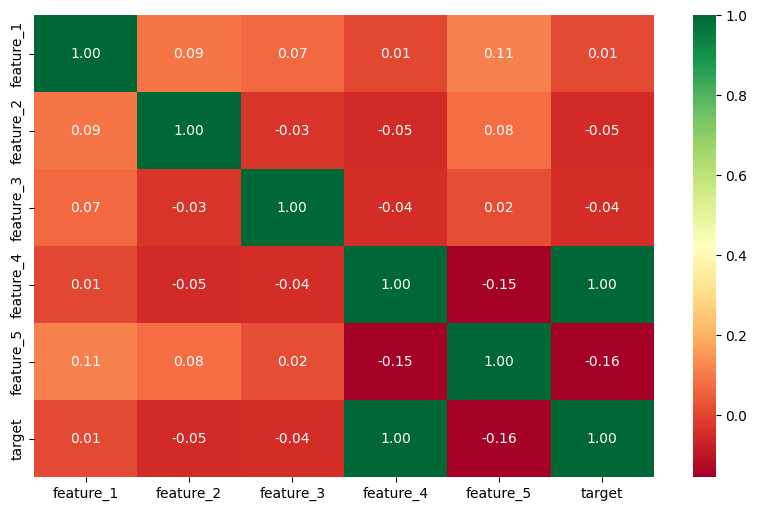

Ознаки, що корелюють з цільовою змінною на більш ніж None за модулем
Незалежна змінна     Кореляція з цільовою змінною target
feature_1                0.0075
feature_2               -0.0500
feature_3               -0.0429
feature_4                0.9997
feature_5               -0.1551
target                   1.0000


In [ ]:
corr_vals = corr_target_measure(df=df, target_variable="target", visualize=True)

Бачимо, що наявна виcока позитивна кореляція між змінною feature_4 та target. Скоріше за все присутня мультиколінеарність, тож варто спробувати видалити цю ознаку і подивитьсь на результати моделювання.

In [ ]:
input_cols = [col for col in reg_rew_df.columns if col not in  ['target', 'feature_4']]
target_col = 'target'

In [ ]:
train_inputs_ = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

test_inputs_ = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import ElasticNet, Ridge, Lasso

models = [
    ('linear_reg', LinearRegression()),
    ('elastic_net', ElasticNet()),
    ('ridge', Ridge()),
    ('lasso', Lasso())
]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pol', PolynomialFeatures(degree=20)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols),
    ])

pipelines = {}

for model_name, model in models:
    pipelines[model_name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])


In [ ]:
linear_reg = pipelines['linear_reg']
lasso = pipelines['lasso']
ridge = pipelines['ridge']
el_net = pipelines['elastic_net']

In [ ]:
linear_reg.fit(train_inputs_, train_targets)
lasso.fit(train_inputs_, train_targets)
ridge.fit(train_inputs_, train_targets)
el_net.fit(train_inputs_, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pol',
                                                                   PolynomialFeatures(degree=20))]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3',
                                                   'feature_5'])])),
                ('classifier', ElasticNet())])

Loss: 0.0031125706942921193


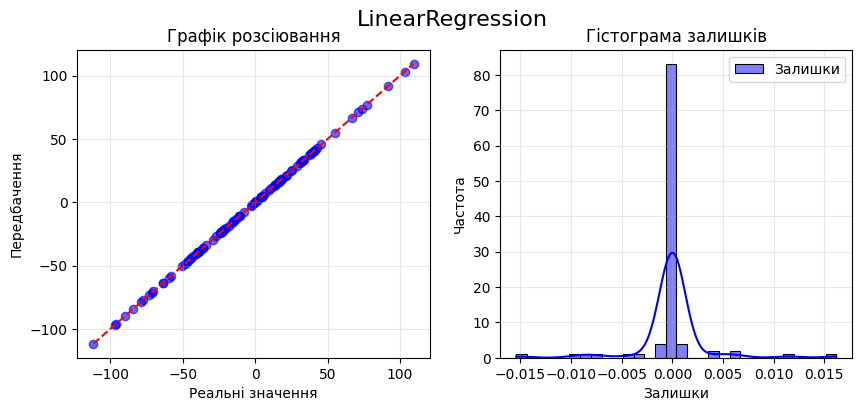

Loss: 3329208.603213135


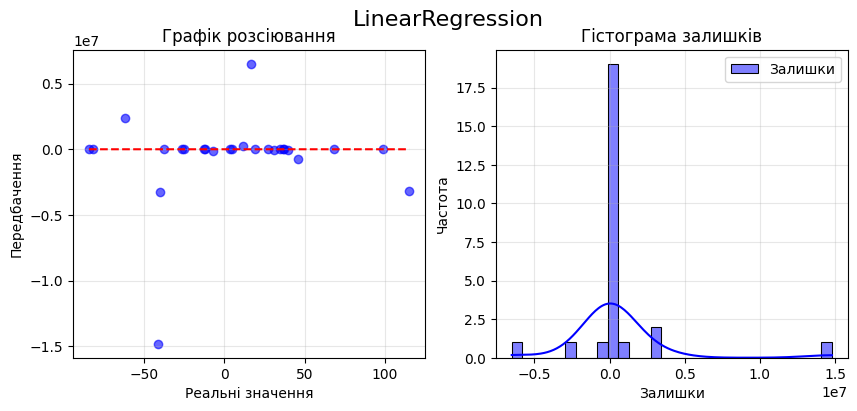

In [ ]:
evaluate(linear_reg, train_inputs_, train_targets, name='LinearRegression')
evaluate(linear_reg, test_inputs_, test_targets, name='LinearRegression')

Loss: 25.919052671093837


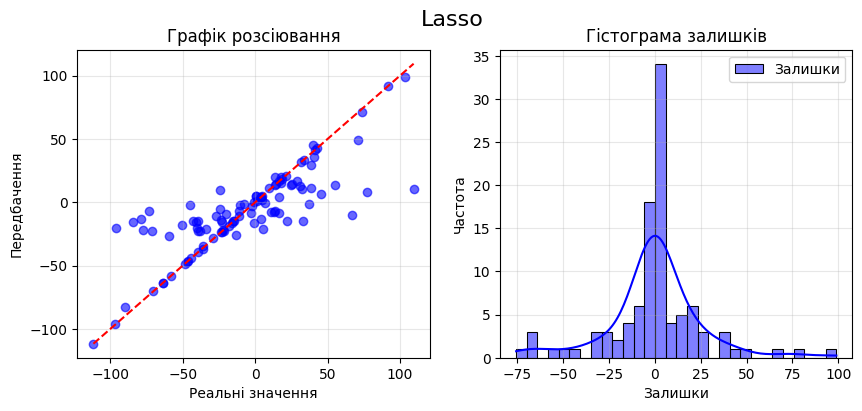

Loss: 92.66189351955335


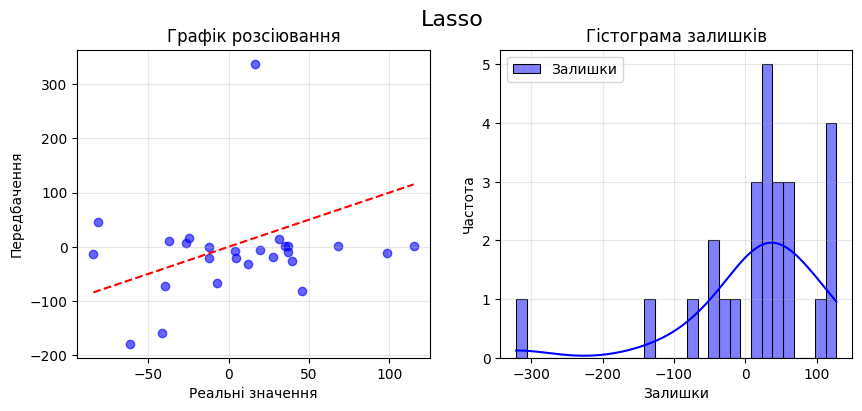

In [ ]:
evaluate(lasso, train_inputs_, train_targets, name='Lasso')
evaluate(lasso, test_inputs_, test_targets, name='Lasso')

Loss: 32.237397282583665


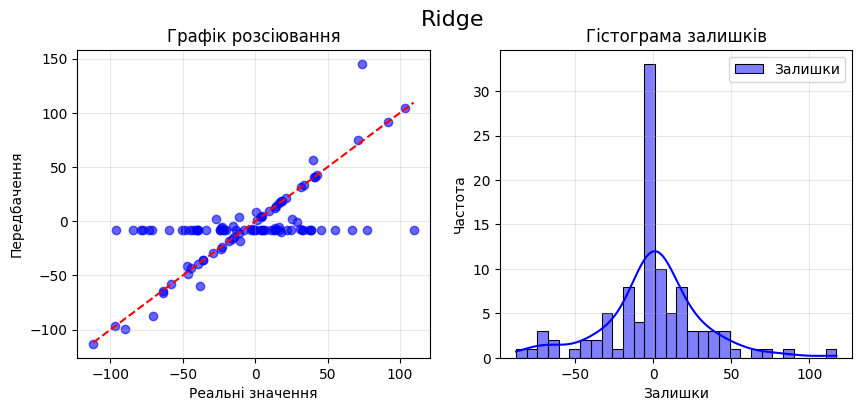

Loss: 4944.704957100382


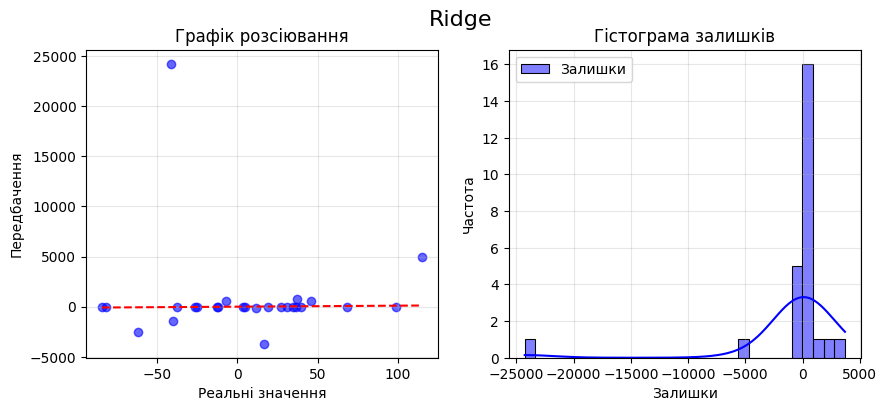

In [ ]:
evaluate(ridge, train_inputs_, train_targets, name='Ridge')
evaluate(ridge, test_inputs_, test_targets, name='Ridge')

Loss: 27.281973757052935


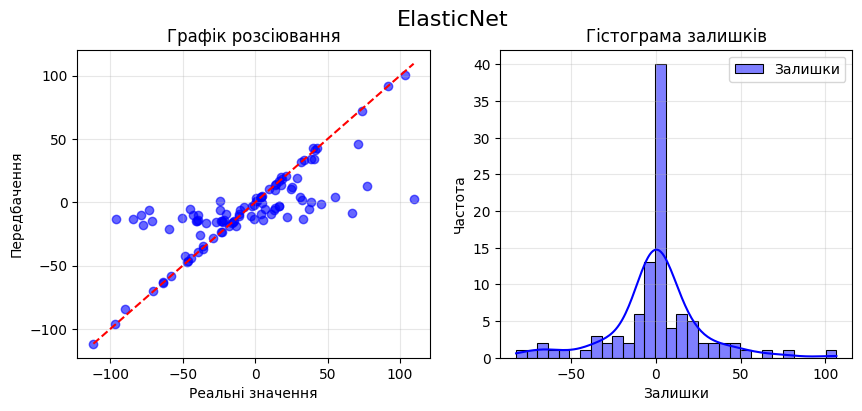

Loss: 97.19537709212047


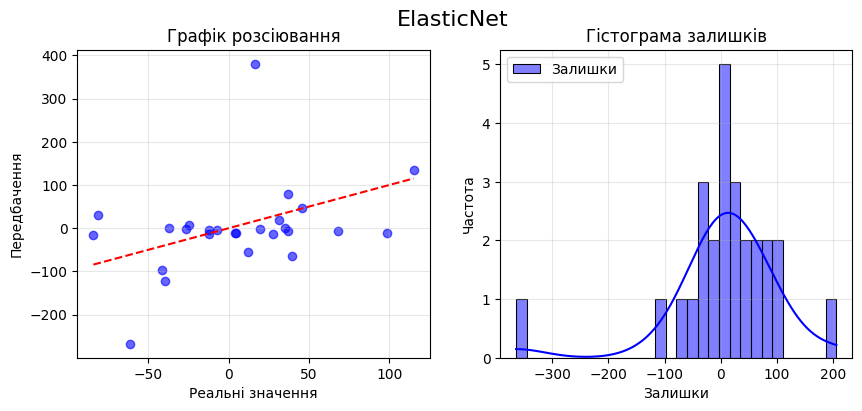

In [ ]:
evaluate(el_net, train_inputs_, train_targets, name='ElasticNet')
evaluate(el_net, test_inputs_, test_targets, name='ElasticNet')

**Висновок**:




###### **Висновки**:

***LinearRegression***

Маємо значення RMSE:
- на тренувальних даних: 0.0031
- на тестових даних: 3329208.6032

Маємо низьке значення RMSE, що говорить про те, що модель гарно підлаштувалась під тренувальні дані. В той же час RMSE на тестових даних має дуже велике значення.

Дивалячись на графіки розсіювання, точки ідеально розташовуються по діагональній лінії, розподіл залишків достатньо вузький та залишки дуже близькі до нуля.

Для тестувальних даних можемо спостерігати більше росіювання точок, та ширший розподіл залишків.

***Lasso***

Маємо значення RMSE:
- на тренувальних даних: 25.91905
- на тестових даних: 92.6618

Бачимо вже не таку вулику різницю між значеннями RMSE на тренувальних і тестових даних.  

На діаграмі розсіювання можнмо спостерігати розіювання точкок, а на гістограмі залишків візуально нормальний розподіл з невеликим зміщенням для тренувальних даних.

Для тестувальних даних бачимо значне розсіювання точок, та більш шириший та зміщений розподіл.

В цілому, дя модель генералізує вже краще ніж LinearRegression, та візуалізації показують вже кращу відповідність між реальними та прогнозованими значеннями.


***Ridge***

Маємо значення RMSE:
- на тренувальних даних: 32.2373
- на тестових даних: 4944.7049

Для цієї моделі досить велика різниця між значеннями RMSE.

З діаграм розсіювання видно, що точки розкидані сильніше. Та розподіл залишків для тестових данних значно ширший та зміщений. Можемо зробити висновок, що модель досить погано генералізує.

***ElasticNet***

Маємо значення RMSE:
- на тренувальних даних: 27.2819
- на тестових даних:  97.1953

В цілому результати досить схожі на результати моделювання з Lasso.

З діаграми розсіювання басичомо, що присуній розкид точок, а з гістограми залишків бачимо, що розподіл візуально схожий на нормальний та дещо вужчий ніж у випадку з Lasso.

Для тестувальних даних більш виражене розсіювання точок, та ширший розподіл залишків відносно тренувальних даних.

_____

В результати видалення ознаки **feature_4**, що мала кореляцію 0.9997 з таргет змінною, припускаючи мультиколінеарність, можемо відмітити, що моделі Lasso та ElasticNet показують найкращі результати на тестовому наборі, з меншим перенавчанням у порівнянні з Linear Regression та Ridge. Та у порівнянні з моделюванням без видалення ознаки feature_4.


В цілому після видалення feature_4 всі моделі продемонстрували кращі результати ніж до видалення.